## Import

In [3]:
import sys,glob,datetime,os,gc,cftime
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import cartopy
sys.path.append('/home/u/u290372/scripts/')
from cartopy_features import *

sys.path.append('/home/u/u290372/scripts/preprocesseing_levante/')
import _pre_oneRun as _pre_oneRun

from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import _regTS_ensemble

ERROR 1: PROJ: proj_create_from_database: Open of /home/u/u290372/.conda/envs/py_main/share/proj failed


In [4]:
class gridded():
    def __init__(self, data):
        self._data = data
        self._Nruns = len(self._data.SMR.values)

    def get_lats_lons_simple(self):
        self._lons = np.array(list(self._data.lon.values) + [self._data.lon[-1]+np.diff(self._data.lon,1).mean()]) - np.diff(self._data.lon,1).mean() * 0.5
        self._lats = np.array(list(self._data.lat.values) + [self._data.lat[-1]+np.diff(self._data.lat,1).mean()]) - np.diff(self._data.lat,1).mean() * 0.5
        
    def get_diff(self, period, ref_period, relative=False):
        if relative:
            return (self._data.loc[:,period] - self._data.loc[:,ref_period]) / self._data.loc[:,ref_period] * 100
        else:
            return self._data.loc[:,period] - self._data.loc[:,ref_period]

    def evaluate_ensemble(self, diff):
        ensMedian = diff.median('SMR').compute()
        agree = ensMedian.copy() * 0
        if len(diff.SMR.values) >= 4:
            for SMR in diff.SMR.values:
                agree += np.sign(ensMedian) == np.sign(diff.loc[SMR])
            agree.values[agree.values < 3/4 * diff.shape[0]] = 0
            agree.values[agree.values >= 3/4 * diff.shape[0]] = 1
            agree = agree.compute()
        return ensMedian,agree
    


In [5]:
indicator_dict = {
    'tas' : dict(cmap='RdBu_r', maxabs=0.3, relative=False),
    'txxETCCDI' : dict(cmap='RdBu_r', maxabs=0.3, relative=False),
    'tnnETCCDI' : dict(cmap='RdBu_r', maxabs=0.3, relative=False),
    'rx1dayETCCDI' : dict(cmap='BrBG', maxabs=10, relative=True),
    'tos' : dict(cmap='RdBu_r', maxabs=0.3, relative=False),
    'pr' : dict(cmap='BrBG', maxabs=10, relative=True),
    'siconc' : dict(cmap='PiYG_r', maxabs=5, relative=False),
    'snc' : dict(cmap='PiYG_r', maxabs=5, relative=False),
    'od550aer' : dict(cmap='PiYG_r', maxabs=0.2, relative=False),
}

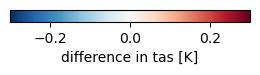

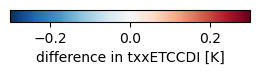

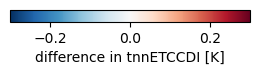

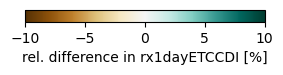

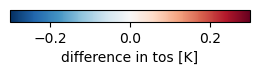

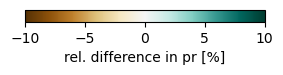

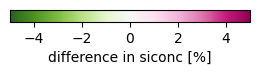

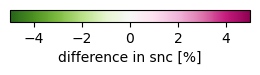

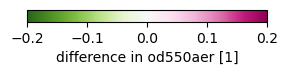

In [6]:
for indicator in indicator_dict.keys():
    cmap,maxabs,relative = indicator_dict[indicator].values()
    plt.figure(figsize=(3, 0.2))
    img = plt.imshow(np.array([[-maxabs,maxabs]]), cmap=cmap)
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    if relative:
        plt.colorbar(orientation="horizontal", cax=cax, label='rel. difference in %s [%s]' %(indicator,'%'))
    else:
        plt.colorbar(orientation="horizontal", cax=cax, label='difference in %s [%s]' %(indicator,_regTS_ensemble.unit_d[indicator]))
    out_name = "/work/uc1275/u290372/overshoot/plots/gridded_maps/cbar_%s.png" %(indicator)
    plt.savefig(out_name.replace('.png','_cbar.png'), transparent=True, bbox_inches='tight', dpi=300)

In [10]:
regio = _regTS_ensemble.regTS_ensemble(region_name='ARO-ocean', realm='Amon', indicator='tas', scenario='*' , esm='*', run='*')
regio.load_existing_object()

True

In [ ]:
for indicator in ['tas']:
    cmap,maxabs,relative = indicator_dict[indicator].values()
    
    esms = sorted(np.unique([fl.split('/')[-1].split('_')[0] for fl in 
                        glob.glob('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/*periods.nc' %(indicator))]))
    
    for esm in esms:
        print(esm)
        for scenario in ['ssp119','ssp534-over','']:
            files = glob.glob('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s*periods.nc' %(indicator,esm, scenario))
            if len(files) > 0:
            
                
                data = xr.open_mfdataset('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s*periods.nc' %(indicator,esm,scenario),
                                     combine='nested', concat_dim='SMR')                
                data = data[indicator].load()
                # select only runs used in later analysis
                SMRs = regio.get_smrs_for_model(esm)
                data = data[np.isin(data.SMR.values,SMRs)]
                
                data = data[np.isfinite(data[:,3].mean(('lat','lon')).values)]
                oo = gridded(data)
                oo.get_lats_lons_simple()
                diff = oo.get_diff('-0.1a', '-0.1b', relative)
                ensMedian,agree = oo.evaluate_ensemble(diff)

                out_name = "/work/uc1275/u290372/overshoot/plots/gridded_maps/per_model/diff_%s_%s_%s_%s_vs_%s.png" \
                        %(indicator,esm,scenario,'-0.1a','-0.1b')
                
                fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), subplot_kw={'projection': cartopy.crs.Robinson()})
                ax.add_feature(coastline, edgecolor='k', zorder=10)
                ax.pcolormesh(oo._lons, oo._lats, ensMedian, vmin=-maxabs, vmax=maxabs, cmap=cmap, transform=cartopy.crs.PlateCarree(), zorder=2)
                ax.annotate('(%s)' %(oo._Nruns), xy=(0.95,0.05), xycoords='axes fraction', ha='right', va='bottom')
                plt.savefig(out_name, transparent=True, bbox_inches='tight', dpi=300)
                
                fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), subplot_kw={'projection': cartopy.crs.Robinson()})
                ax.add_feature(coastline, edgecolor='k', zorder=10)
                ax.contourf(agree.lon, agree.lat, agree, levels=[-0.5,0.5,1.5], hatches=['','////'], colors=['none','none'], 
                              transform=cartopy.crs.PlateCarree(), zorder=3)
                plt.savefig(out_name.replace('.png','_agreement.png'), transparent=True, bbox_inches='tight', dpi=300)

    plt.clf()

## For the perspective paper
only runs that go until -0.2K

In [110]:
indicator_dict = {
    'tas' : dict(cmap='RdBu_r', maxabs=0.5, relative=False),
    'pr' : dict(cmap='BrBG', maxabs=5, relative=True),
}

In [ ]:
for indicator in ['tas','pr']:
    cmap,maxabs,relative = indicator_dict[indicator].values()
    
    esms = sorted(np.unique([fl.split('/')[-1].split('_')[0] for fl in 
                        glob.glob('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/*periods.nc' %(indicator))]))
    
    
    l,used_esms = [],[]
    for esm in esms:
        for scenario in ['ssp119','ssp534-over']:
            files = glob.glob('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s*periods.nc' %(indicator,esm, scenario))
            if len(files) > 0:
                data = xr.open_mfdataset('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s*periods.nc' %(indicator,esm,scenario),
                                     combine='nested', concat_dim='SMR')                
                data = data[indicator].load()
                # select only runs used in later analysis
                SMRs = regio.get_smrs_for_model(esm)
                data = data[np.isin(data.SMR.values,SMRs)]
                
                data = data[np.isfinite(data[:,4].mean(('lat','lon')).values)]
                oo = gridded(indicator, None)
                oo._data = data
                l += [data]

    oo = gridded(indicator, None)           
    oo._data = xr.concat(l, dim='SMR')
    for period, ref_period in zip(['-0.2b','-0.1b','oshoot','-0.1a','-0.2a','-0.1a','-0.2a'], ['oshoot']*5+['-0.1b','-0.2b']):
        diff = oo.get_diff(period,ref_period, relative)
        model_axis = xr.DataArray([smr.split('_')[1] for smr in diff.SMR.values], dims=['SMR'], coords=dict(SMR=diff.SMR.values))
        diff = diff.groupby(model_axis).median()
        diff = diff.rename({'group':'SMR'})

        oo.get_lats_lons_simple()
        oo._Nruns = len(oo._data.SMR.values)
        ensMedian,agree = oo.evaluate_ensemble(diff)


        out_name = "/work/uc1275/u290372/overshoot/plots/gridded_maps/diff_perspective_%s_%s_vs_%s.png" \
                        %(indicator,period,ref_period)

        fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), subplot_kw={'projection': cartopy.crs.Robinson()})
        ax.add_feature(coastline, edgecolor='k', zorder=10)
        ax.pcolormesh(self._lons, self._lats, ensMedian, vmin=-maxabs, vmax=maxabs, cmap=cmap, transform=cartopy.crs.PlateCarree(), zorder=2)
        ax.contourf(agree.lon, agree.lat, agree, levels=[-0.5,0.5,1.5], hatches=['','////'], colors=['none','none'], 
                      transform=cartopy.crs.PlateCarree(), zorder=3)
        plt.savefig(out_name, transparent=True, bbox_inches='tight', dpi=300)

        plt.figure(figsize=(3, 0.2))
        img = plt.imshow(np.array([[-maxabs,maxabs]]), cmap=cmap)
        plt.gca().set_visible(False)
        cax = plt.axes([0.1, 0.2, 0.8, 0.6])
        if relative:
            plt.colorbar(orientation="horizontal", cax=cax, label='rel. difference in %s [%s]' %(indicator,'%'))
        else:
            plt.colorbar(orientation="horizontal", cax=cax, label='difference in %s [%s]' %(indicator,_regTS_ensemble.unit_d[indicator]))
        plt.savefig(out_name.replace('.png','_cbar.png'), transparent=True, bbox_inches='tight', dpi=300)
    

In [113]:
print(', '.join(np.unique([smr.split('_')[1] for smr in oo._data.SMR.values])))

CESM2-WACCM, CanESM5, EC-Earth3, FGOALS-g3, GFDL-ESM4, GISS-E2-1-G, IPSL-CM6A-LR, MIROC-ES2L, MIROC6, MPI-ESM1-2-LR, MRI-ESM2-0, UKESM1-0-LL


## Arctic

ACCESS-ESM1-5
CESM2-WACCM
CanESM5
EC-Earth3
EC-Earth3-Veg-LR
FGOALS-g3
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-LR
MRI-ESM2-0
UKESM1-0-LL
CESM2-WACCM
CanESM5
EC-Earth3
EC-Earth3-Veg-LR
FGOALS-g3
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-LR
MRI-ESM2-0
UKESM1-0-LL


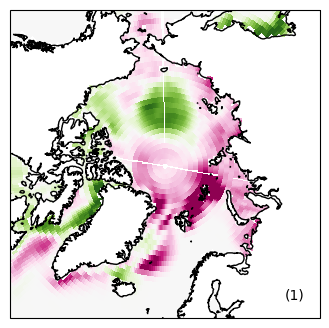

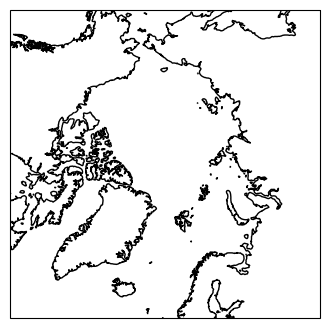

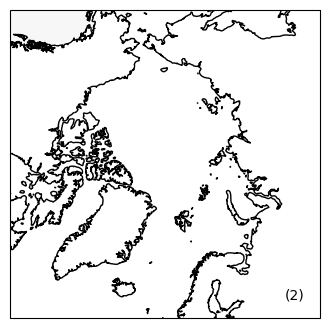

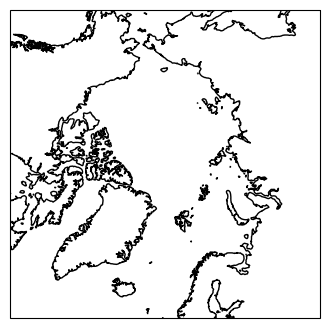

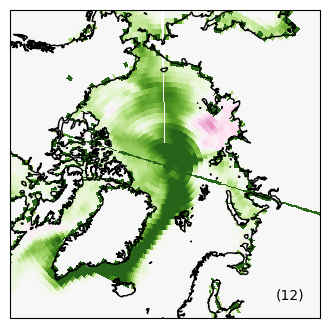

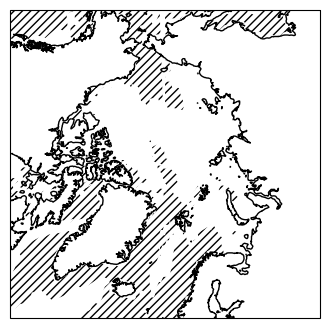

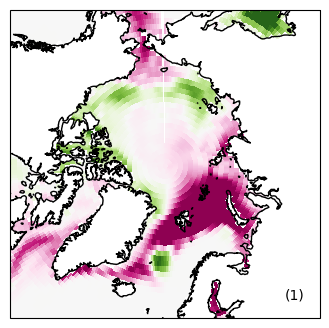

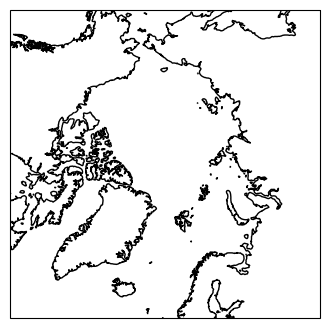

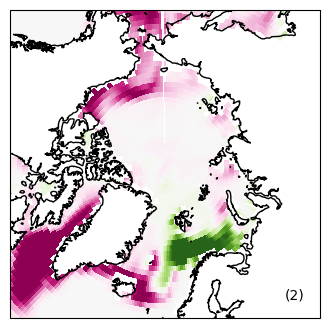

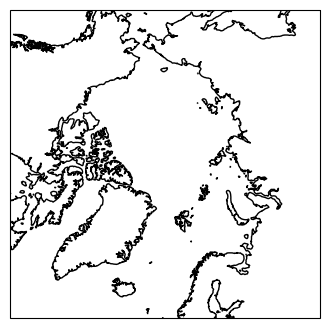

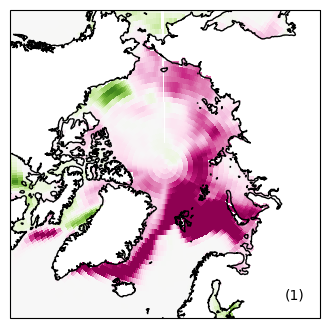

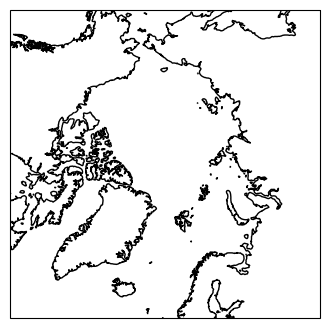

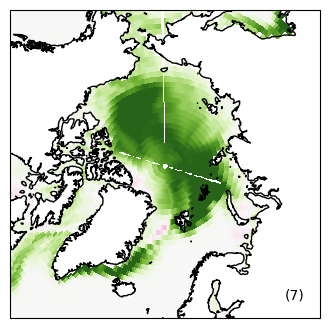

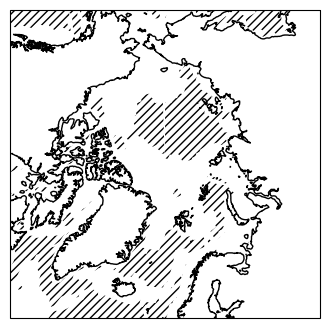

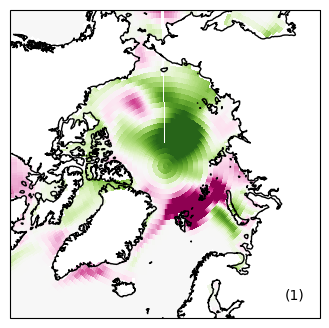

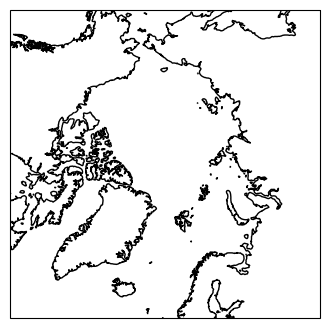

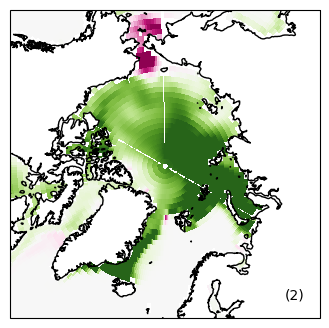

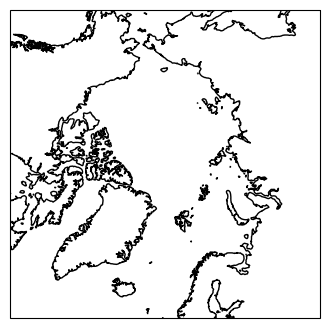

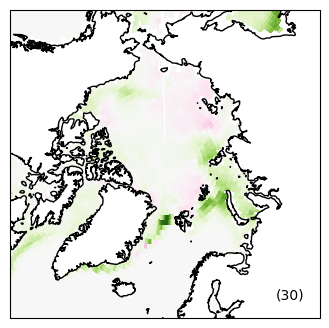

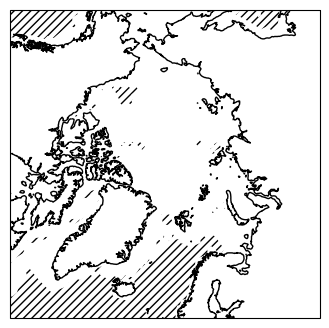

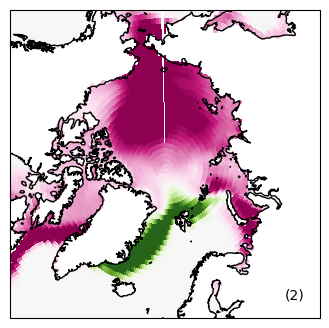

<Figure size 600x400 with 0 Axes>

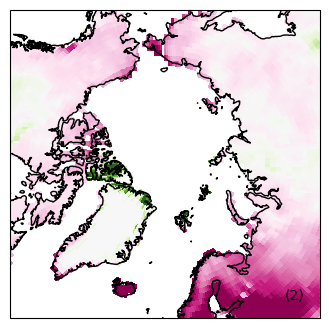

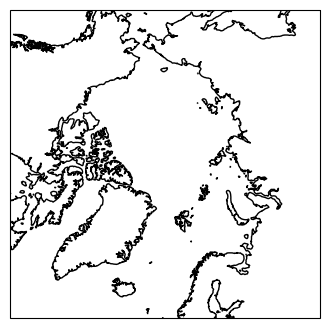

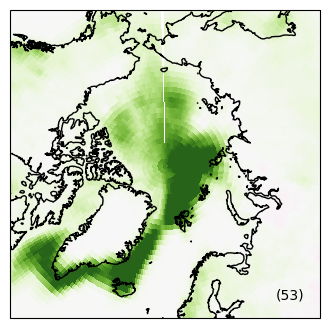

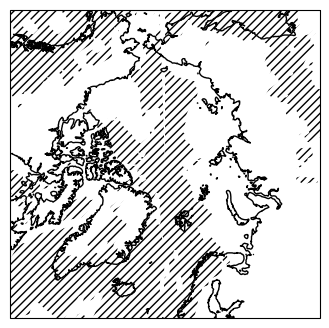

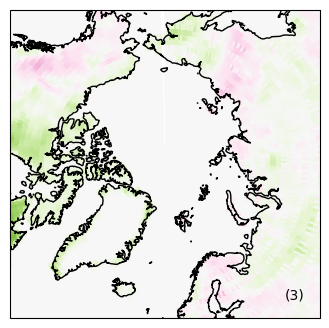

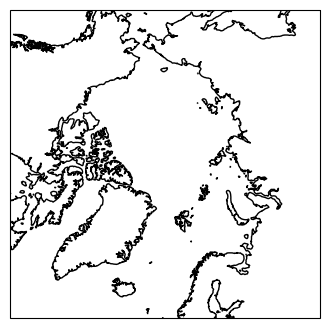

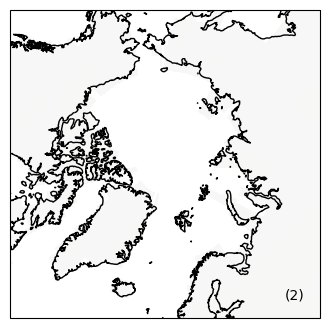

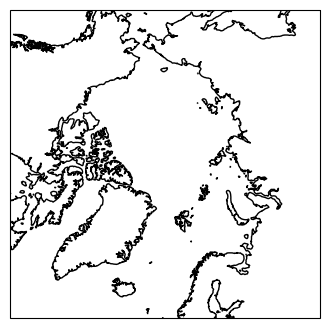

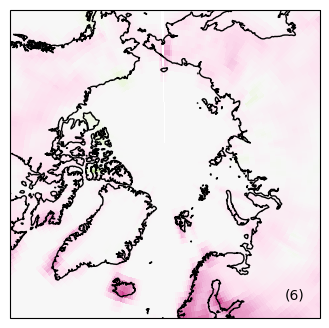

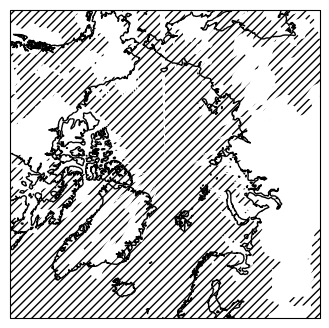

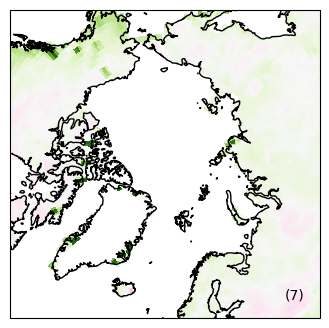

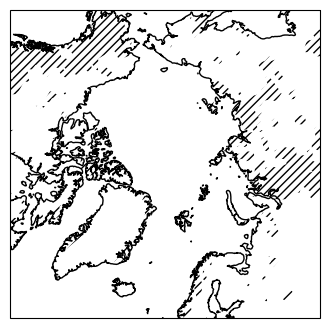

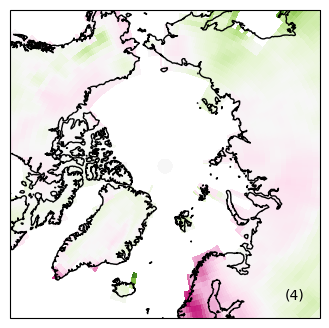

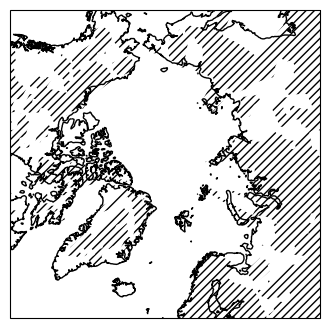

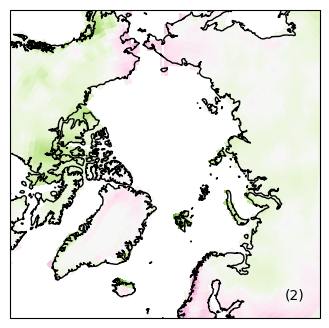

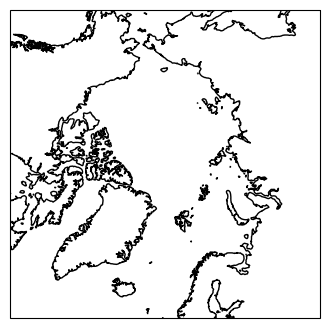

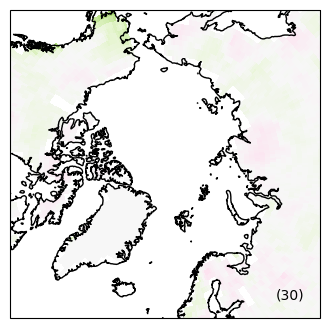

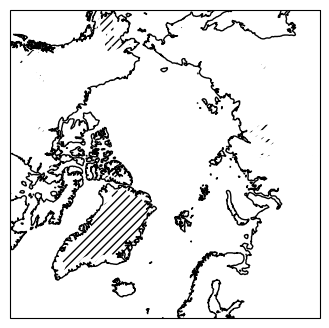

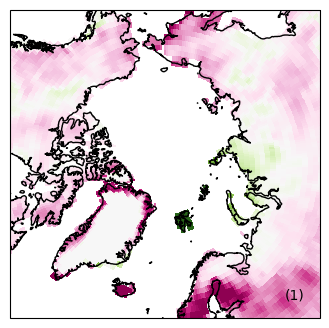

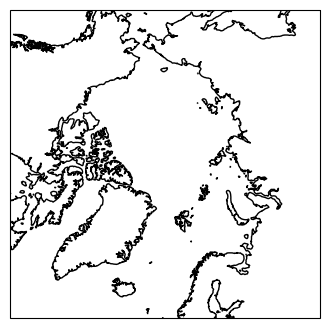

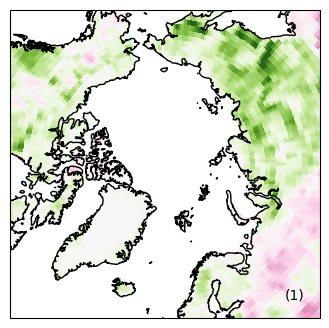

<Figure size 600x400 with 0 Axes>

In [10]:
regio = _regTS_ensemble.regTS_ensemble(region_name='ARO-ocean', realm='Amon', indicator='tas', scenario='*' , esm='*', run='*')
regio.load_existing_object()
for indicator in ['siconc','snc']: #'tos','tas',
    cmap,maxabs,relative = indicator_dict[indicator].values()
    
    esms = sorted(np.unique([fl.split('/')[-1].split('_')[0] for fl in 
                        glob.glob('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/*periods.nc' %(indicator))]))
    
    for esm in esms:
        print(esm)
        for scenario in ['']:
            files = glob.glob('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s*periods.nc' %(indicator,esm, scenario))
            if len(files) > 0:
            
                
                data = xr.open_mfdataset('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s*periods.nc' %(indicator,esm,scenario),
                                     combine='nested', concat_dim='SMR')                
                data = data[indicator].load()
                # select only runs used in later analysis
                SMRs = regio.get_smrs_for_model(esm)
                data = data[np.isin(data.SMR.values,SMRs)]
                
                data = data[np.isfinite(data[:,3].mean(('lat','lon')).values)]
                oo = gridded(data)
                oo.get_lats_lons_simple()
                diff = oo.get_diff('-0.1a', '-0.1b', relative)
                ensMedian,agree = oo.evaluate_ensemble(diff)

                if oo._Nruns > 0:
                    out_name = "/work/uc1275/u290372/overshoot/plots/gridded_maps/per_model/diff_%s_%s_%s_%s_vs_%s_arctic.png" \
                            %(indicator,esm,scenario,'-0.1a','-0.1b')

                    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), subplot_kw={'projection': cartopy.crs.NorthPolarStereo()})
                    ax.set_extent([-180,180,60,90], crs=cartopy.crs.PlateCarree()) 
                    ax.add_feature(coastline, edgecolor='k', zorder=10)
                    ax.pcolormesh(oo._lons, oo._lats, ensMedian, vmin=-maxabs, vmax=maxabs, cmap=cmap, transform=cartopy.crs.PlateCarree(), zorder=2)
                    ax.annotate('(%s)' %(oo._Nruns), xy=(0.95,0.05), xycoords='axes fraction', ha='right', va='bottom')
                    plt.savefig(out_name, transparent=True, bbox_inches='tight', dpi=300)

                    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), subplot_kw={'projection': cartopy.crs.NorthPolarStereo()})
                    ax.set_extent([-180,180,60,90], crs=cartopy.crs.PlateCarree())
                    ax.add_feature(coastline, edgecolor='k', zorder=10)
                    ax.contourf(agree.lon, agree.lat, agree, levels=[-0.5,0.5,1.5], hatches=['','////'], colors=['none','none'], 
                                  transform=cartopy.crs.PlateCarree(), zorder=3)
                    plt.savefig(out_name.replace('.png','_agreement.png'), transparent=True, bbox_inches='tight', dpi=300)

    plt.clf()